In [6]:
pip install numpy scipy librosa soundfile pypesq

Note: you may need to restart the kernel to use updated packages.


Input file 1 sampling rate is already 16000 Hz.
Starting Plain LPC Vocoder for file 1...
Plain LPC Vocoder: Runtime = 0.54 seconds
Starting Voice-Excited LPC Vocoder for file 1...
Voice-Excited LPC Vocoder: Runtime = 2.17 seconds
File 1: Segmental SNR (Plain LPC): -2.05 dB
File 1: Segmental SNR (Voice-Excited LPC): -5.53 dB


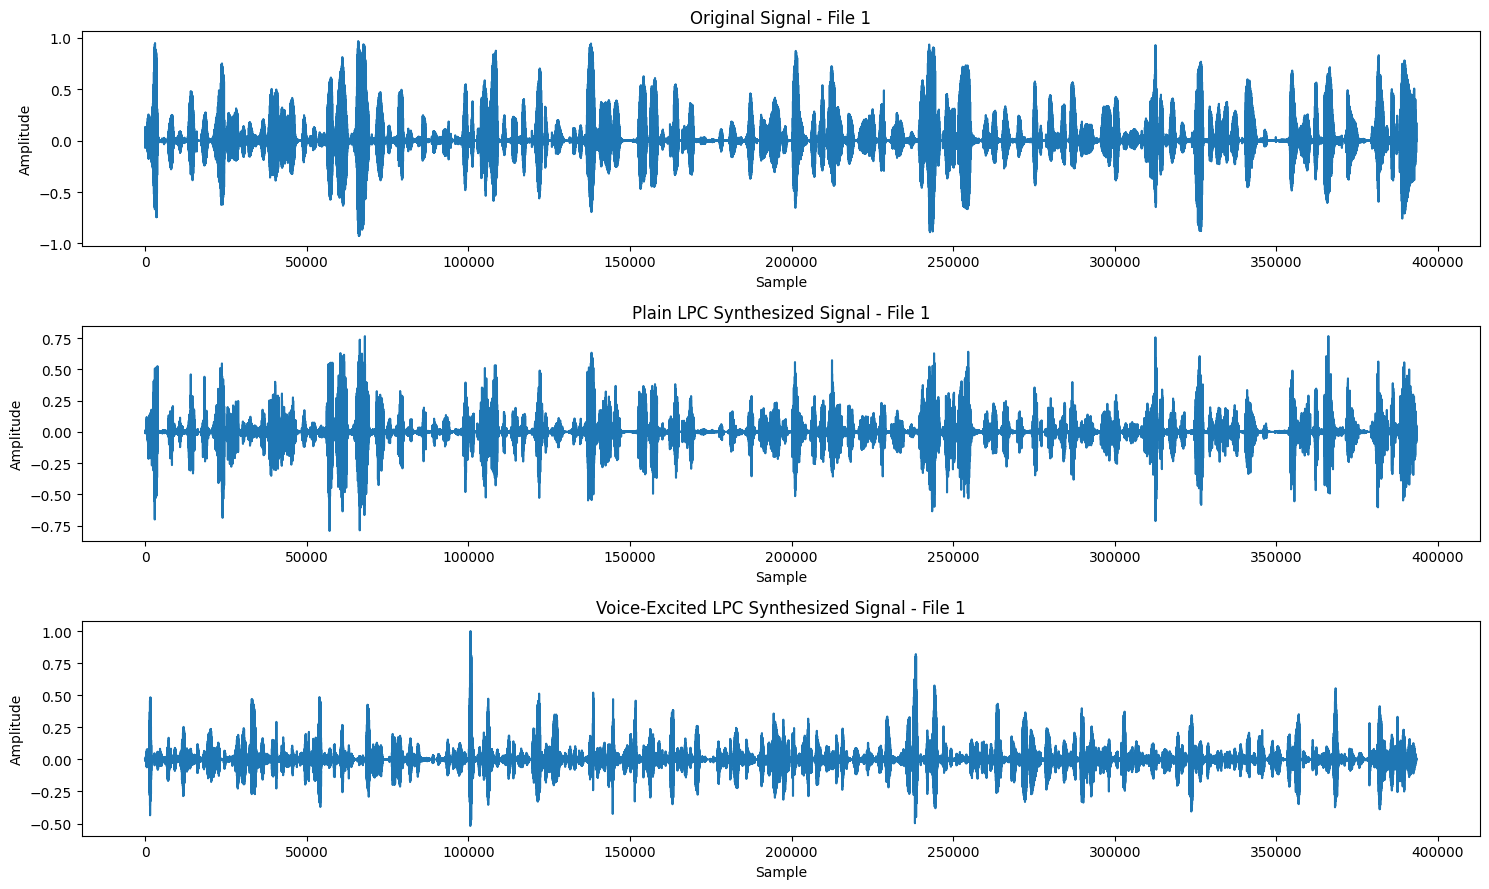

/tmp/ipykernel_141/3674484328.py:376: WavFileWarning: Reached EOF prematurely; finished at 237636 bytes, expected 241580 bytes from header.
  original_fs, original_signal = wav.read(input_file)


Input file 2 sampling rate is already 16000 Hz.
Starting Plain LPC Vocoder for file 2...
Plain LPC Vocoder: Runtime = 0.19 seconds
Starting Voice-Excited LPC Vocoder for file 2...
Voice-Excited LPC Vocoder: Runtime = 0.69 seconds
File 2: Segmental SNR (Plain LPC): -1.23 dB
File 2: Segmental SNR (Voice-Excited LPC): -1.38 dB


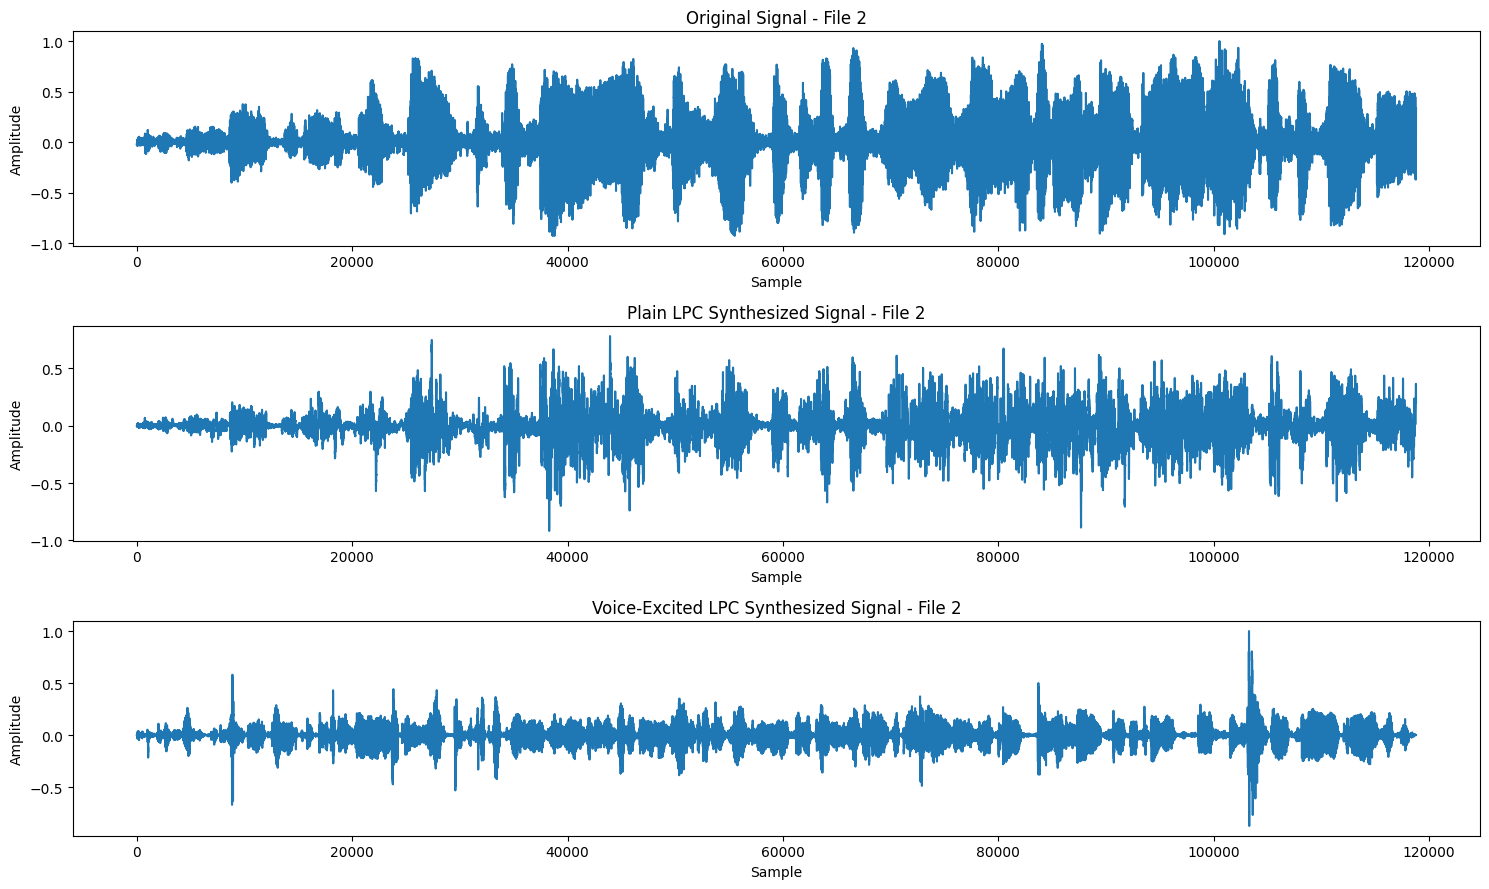

Input file 3 sampling rate is already 16000 Hz.
Starting Plain LPC Vocoder for file 3...
Plain LPC Vocoder: Runtime = 0.57 seconds
Starting Voice-Excited LPC Vocoder for file 3...
Voice-Excited LPC Vocoder: Runtime = 2.28 seconds
File 3: Segmental SNR (Plain LPC): -1.91 dB
File 3: Segmental SNR (Voice-Excited LPC): -8.09 dB


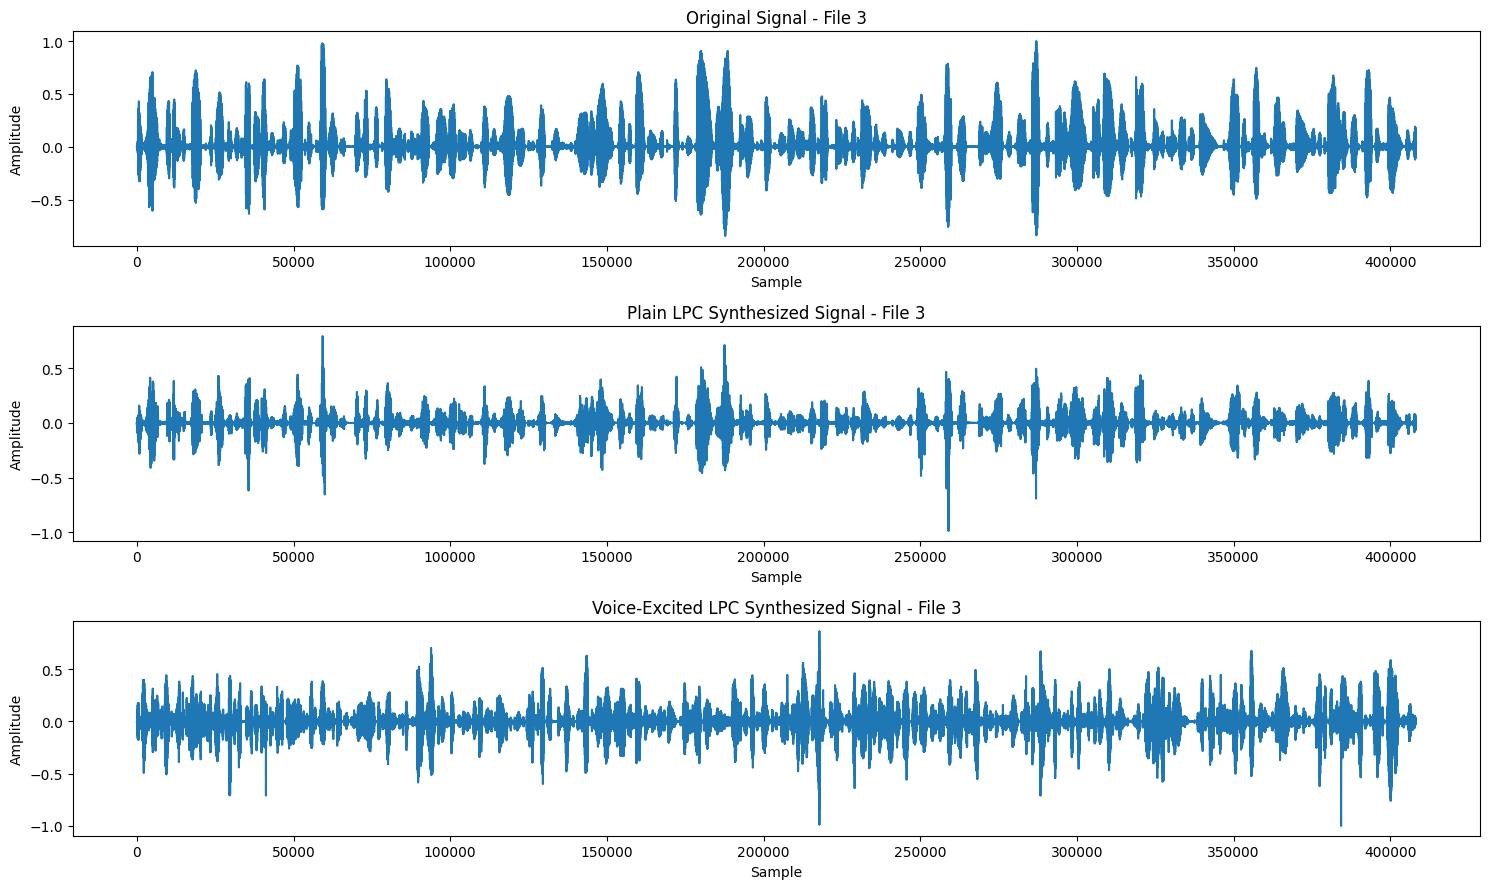

Input file 4 sampling rate is already 16000 Hz.
Starting Plain LPC Vocoder for file 4...
Plain LPC Vocoder: Runtime = 0.18 seconds
Starting Voice-Excited LPC Vocoder for file 4...
Voice-Excited LPC Vocoder: Runtime = 0.75 seconds
File 4: Segmental SNR (Plain LPC): -0.99 dB
File 4: Segmental SNR (Voice-Excited LPC): -3.51 dB


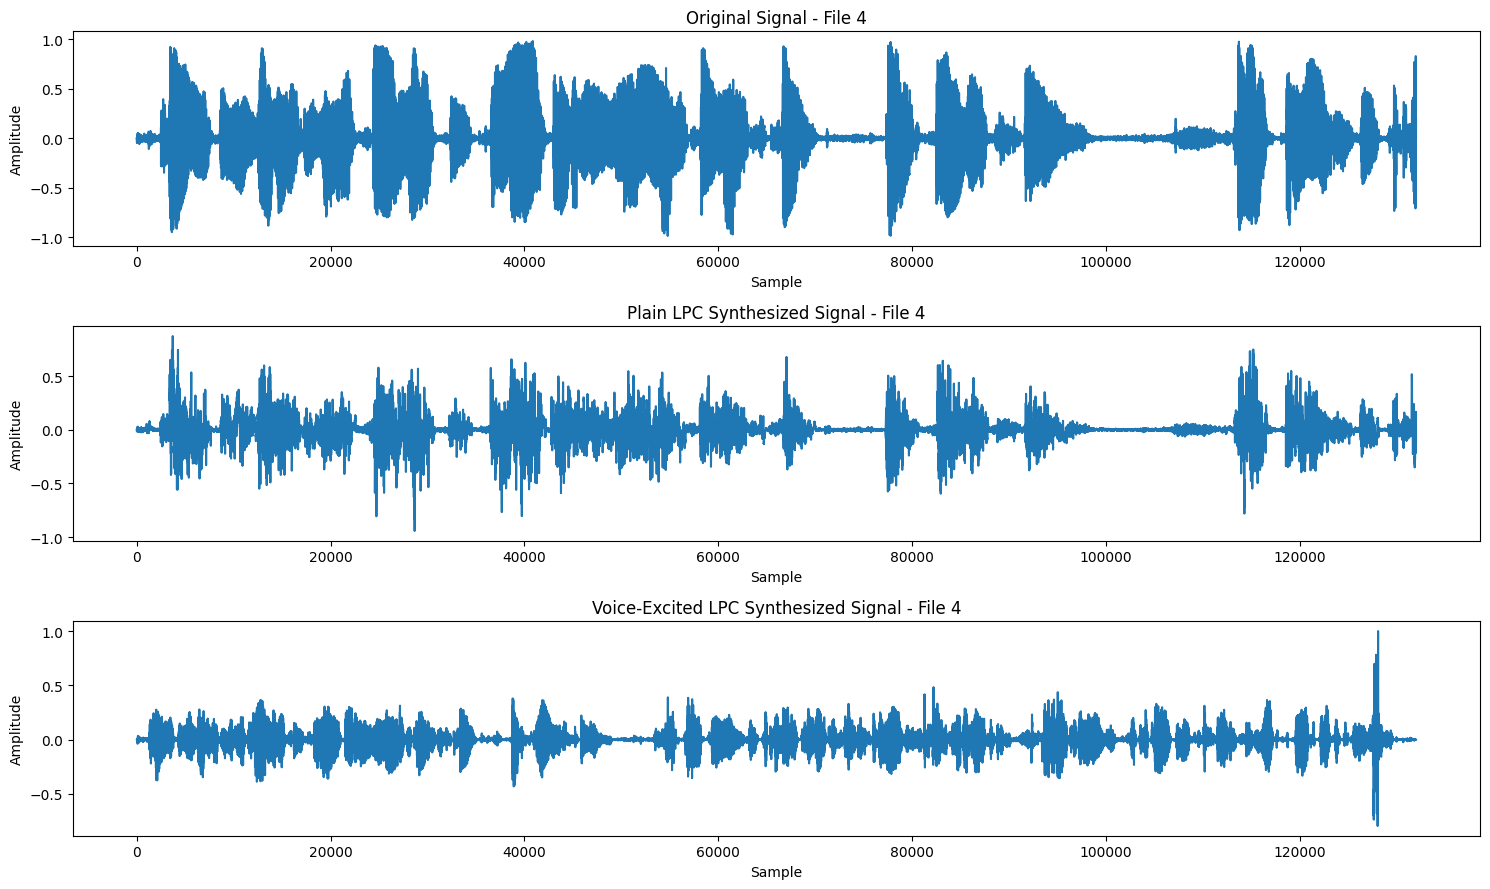

In [26]:
import numpy as np
import scipy.io.wavfile as wav
import scipy.signal as signal
from scipy.signal import lfilter, correlate, find_peaks, resample_poly
from scipy.signal.windows import hamming
from scipy.linalg import toeplitz
from scipy.fftpack import dct, idct
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import os
import time

# Function to resample the signal
def resample_signal(signal, original_fs, target_fs):
    """
    Resample the input signal from original_fs to target_fs using polyphase filtering.
    """
    gcd = np.gcd(original_fs, target_fs)
    up = target_fs // gcd
    down = original_fs // gcd
    return resample_poly(signal, up, down)

# Function to safely normalize signals
def safe_normalize(signal):
    """
    Safely normalize a signal to the range [-1, 1].
    """
    max_val = np.max(np.abs(signal))
    return signal / max_val if max_val > 0 else np.zeros_like(signal)

# Function to stabilize LPC filter coefficients
def stabilize_lpc_filter(coeffs):
    """
    Stabilize LPC filter coefficients to ensure the filter is stable.
    Reflects any roots outside the unit circle back inside.
    """
    if np.any(np.isnan(coeffs)) or np.any(np.isinf(coeffs)):
        return np.zeros_like(coeffs)
    
    # Compute the roots of the LPC polynomial
    roots = np.roots(np.hstack(([1], -coeffs)))
    
    # Reflect roots outside the unit circle
    for i, r in enumerate(roots):
        if np.abs(r) > 1:
            roots[i] = 1 / np.conj(r)
    
    # Recompute the LPC coefficients from the stabilized roots
    stabilized_coeffs = np.real(np.poly(roots))
    
    return stabilized_coeffs[1:]

# Function to estimate pitch period using autocorrelation
def estimate_pitch(frame, fs, min_pitch=50, max_pitch=500):
    """
    Estimate pitch period using autocorrelation within a specified pitch range.
    
    Parameters:
        frame (np.ndarray): The audio frame.
        fs (int): Sampling frequency.
        min_pitch (int): Minimum pitch in Hz.
        max_pitch (int): Maximum pitch in Hz.
    
    Returns:
        int: Estimated pitch period in samples. Returns 0 if unvoiced.
    """
    min_period = int(fs / max_pitch)
    max_period = int(fs / min_pitch)
    
    # Compute autocorrelation
    autocorr = correlate(frame, frame, mode='full')
    autocorr = autocorr[len(frame)-1:]
    
    # Search for peak in the specified pitch range
    search_range = autocorr[min_period:max_period]
    if len(search_range) == 0:
        return 0  # Unable to estimate pitch
    
    peak = np.argmax(search_range) + min_period
    peak_value = autocorr[peak]
    
    # Voicing decision based on peak value
    if peak_value < 0.3 * autocorr[0]:
        return 0  # Consider as unvoiced
    
    return peak

# Function to calculate Segmental SNR
def calculate_segmental_snr(original, synthesized, frame_length, fs):
    """
    Calculate the Segmental Signal-to-Noise Ratio (SNR) between original and synthesized signals.
    
    Parameters:
        original (np.ndarray): Original audio signal.
        synthesized (np.ndarray): Synthesized audio signal.
        frame_length (int): Frame length in milliseconds.
        fs (int): Sampling frequency.
    
    Returns:
        float: Average Segmental SNR in dB.
    """
    segment_length = int(fs * frame_length / 1000)
    num_segments = len(original) // segment_length
    snr_sum = 0
    valid_segments = 0

    for i in range(num_segments):
        start = i * segment_length
        end = start + segment_length
        original_segment = original[start:end]
        synthesized_segment = synthesized[start:end]
        signal_energy = np.sum(original_segment ** 2)
        noise_energy = np.sum((original_segment - synthesized_segment) ** 2)

        if signal_energy > 0 and noise_energy > 0:
            snr_sum += 10 * np.log10(signal_energy / noise_energy)
            valid_segments += 1

    return snr_sum / valid_segments if valid_segments > 0 else float('-inf')

# Improved LPC Analysis with Stability Check
def lpc_analysis(frame, order):
    """
    Compute LPC coefficients and gain with stability check.
    
    Parameters:
        frame (np.ndarray): Windowed frame of audio.
        order (int): LPC order.
    
    Returns:
        tuple: LPC coefficients (A) and gain (G).
    """
    # Autocorrelation
    autocorr = np.correlate(frame, frame, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    R = autocorr[:order+1]
    
    # Solve Toeplitz system
    try:
        A = np.linalg.solve(toeplitz(R[:-1]), -R[1:])
    except np.linalg.LinAlgError:
        # If matrix is singular, return zeros
        A = np.zeros(order)
    A = np.concatenate(([1], A))
    
    # Check for filter stability
    if not is_stable(A):
        A = np.array([1] + [0]*order)
    
    # Gain computation
    G = np.sqrt(R[0] + np.dot(R[1:], A[1:]))
    return A, G

# Function to check LPC filter stability
def is_stable(A):
    """
    Check if the LPC filter is stable.
    
    Parameters:
        A (np.ndarray): LPC coefficients.
    
    Returns:
        bool: True if stable, False otherwise.
    """
    roots = np.roots(A)
    return np.all(np.abs(roots) < 1)

# Function to determine if frame is voiced or unvoiced
def is_voiced(frame, fs):
    """
    Determine if a frame is voiced based on energy and zero-crossing rate.
    
    Parameters:
        frame (np.ndarray): Audio frame.
        fs (int): Sampling frequency.
    
    Returns:
        bool: True if voiced, False otherwise.
    """
    energy = np.sum(frame ** 2) / len(frame)
    zcr = ((frame[:-1] * frame[1:]) < 0).sum() / len(frame)
    threshold_energy = 0.02  # Adjust as needed
    threshold_zcr = 0.1
    return energy > threshold_energy and zcr < threshold_zcr

# Function to generate excitation signal for Plain LPC Vocoder
def generate_excitation_plain(frame_length, voiced, pitch_period=None):
    """
    Generate excitation signal for plain LPC vocoder.
    
    Parameters:
        frame_length (int): Length of the frame in samples.
        voiced (bool): Whether the frame is voiced.
        pitch_period (int or None): Pitch period in samples if voiced.
    
    Returns:
        np.ndarray: Excitation signal.
    """
    if voiced and pitch_period is not None and pitch_period > 0:
        excitation = np.zeros(frame_length)
        # Generate a pulse train with exact pitch period
        for n in range(0, frame_length, pitch_period):
            if n < frame_length:
                excitation[n] = 1.0
    else:
        excitation = np.random.randn(frame_length)
    return excitation

# Improved Plain LPC Vocoder
def plain_lpc_vocoder(input_file, output_file, lpc_order=12, frame_size=0.03, fs_target=16000):
    """
    Improved Plain LPC vocoder for speech synthesis.
    
    Parameters:
        input_file (str): Path to the input WAV file.
        output_file (str): Path to save the output WAV file.
        lpc_order (int): LPC analysis order.
        frame_size (float): Frame size in seconds.
        fs_target (int): Target sampling rate.
    """
    # Load audio file with librosa to handle resampling if needed
    speech, sr = librosa.load(input_file, sr=fs_target, mono=True)
    fs = sr  # Sampling rate
    
    # Pre-emphasis filter
    pre_emphasis = 0.97
    emphasized_speech = np.append(speech[0], speech[1:] - pre_emphasis * speech[:-1])
    
    frame_length = int(frame_size * fs)
    num_frames = len(emphasized_speech) // frame_length
    synthesized_speech = np.zeros(num_frames * frame_length)
    
    # Window function
    window = np.hamming(frame_length)
    
    start_time = time.time()
    
    for i in range(num_frames):
        frame = emphasized_speech[i*frame_length:(i+1)*frame_length]
        
        # Apply window
        windowed_frame = frame * window
        
        # LPC Analysis
        A, G = lpc_analysis(windowed_frame, lpc_order)
        
        # Voicing Decision
        voiced = is_voiced(windowed_frame, fs)
        pitch_period = estimate_pitch(windowed_frame, fs) if voiced else None
        
        # Generate Excitation Signal
        excitation = generate_excitation_plain(frame_length, voiced, pitch_period)
        
        # Synthesize Speech
        excitation_scaled = excitation * G
        synthesized_frame = signal.lfilter([1], A, excitation_scaled)
        
        # Insert Synthesized Frame
        synthesized_speech[i*frame_length:(i+1)*frame_length] = synthesized_frame
        
        # print(f"Frame {i+1}/{num_frames}: Voiced={voiced}, Pitch Period={pitch_period}, Gain={G:.4f}")
    
    # De-emphasis filter
    synthesized_speech = signal.lfilter([1], [1, -pre_emphasis], synthesized_speech)
    
    # Normalize synthesized speech to prevent clipping
    max_val = np.max(np.abs(synthesized_speech))
    if max_val > 0:
        synthesized_speech = synthesized_speech / max_val * 0.99
    
    # Save output file using soundfile for better compatibility
    sf.write(output_file, synthesized_speech, fs)
    
    runtime = time.time() - start_time
    print(f"Plain LPC Vocoder: Runtime = {runtime:.2f} seconds")

# Voice-Excited LPC Vocoder (Unchanged as per user)
def voice_excited_lpc_vocoder(input_file, output_file, lpc_order=10, frame_size=0.02, frame_shift=0.012, compression_ratio=0.5):
    """
    Voice-excited LPC vocoder.
    
    Parameters:
        input_file (str): Path to the input WAV file.
        output_file (str): Path to save the output WAV file.
        lpc_order (int): LPC analysis order.
        frame_size (float): Frame size in seconds.
        frame_shift (float): Frame shift in seconds.
        compression_ratio (float): Ratio for residual compression.
    """
    # Load audio file
    speech, sr = librosa.load(input_file, sr=None, mono=True)
    fs = sr  # Sampling rate
    
    # Normalize
    speech = safe_normalize(speech)
    
    # Pre-emphasis filter
    pre_emphasis = 0.95
    preemphasized = np.append(speech[0], speech[1:] - pre_emphasis * speech[:-1])
    
    frame_length = int(frame_size * fs)
    frame_step = int(frame_shift * fs)
    num_frames = (len(preemphasized) - frame_length) // frame_step + 1
    synthesized_signal = np.zeros_like(preemphasized)
    window = np.hamming(frame_length)

    start_time = time.time()
    
    for i in range(num_frames):
        start = i * frame_step
        end = start + frame_length
        frame = preemphasized[start:end] * window
        autocorr = correlate(frame, frame, mode='full')[len(frame)-1:]
        R = autocorr[:lpc_order+1]
        
        if len(R) < lpc_order + 1 or np.any(np.isnan(R)) or np.any(np.isinf(R)):
            coeffs = np.zeros(lpc_order)
            residual = frame
        else:
            try:
                R_matrix = toeplitz(R[:-1])
                coeffs = np.linalg.solve(R_matrix, R[1:])
                coeffs = stabilize_lpc_filter(coeffs)
                residual = lfilter(coeffs, [1], frame)
            except np.linalg.LinAlgError:
                coeffs = np.zeros(lpc_order)
                residual = frame
        
        residual_dct = dct(residual, norm='ortho')
        k = int(len(residual_dct) * compression_ratio)
        residual_dct[k:] = 0
        compressed_residual = idct(residual_dct, norm='ortho')
        synthesized_frame = lfilter([0] + [-c for c in coeffs], [1], compressed_residual)
        synthesized_signal[start:end] += synthesized_frame

    # De-emphasis filter
    synthesized_signal = signal.lfilter([1], [1, -pre_emphasis], synthesized_signal)
    
    # Normalize synthesized signal
    synthesized_signal = safe_normalize(synthesized_signal)
    if np.max(np.abs(synthesized_signal)) > 0:
        synthesized_signal = synthesized_signal / np.max(np.abs(synthesized_signal))
    
    # Save output file using soundfile for better compatibility
    sf.write(output_file, synthesized_signal, fs)
    
    runtime = time.time() - start_time
    print(f"Voice-Excited LPC Vocoder: Runtime = {runtime:.2f} seconds")

# Main Execution
if __name__ == "__main__":
    # Define file paths for 4 input files
    input_files = [
        "/kaggle/input/obj2audio/f1.wav",
        "/kaggle/input/obj2audio/f2.wav",
        "/kaggle/input/obj2audio/m1.wav",
        "/kaggle/input/obj2audio/m2.wav"
    ]

    # Desired sampling rate
    target_fs = 16000

    for idx, input_file in enumerate(input_files):
        # Generate dynamic file paths for resampled and output files
        resampled_file = f"/kaggle/working/resampled_input_{idx + 1}.wav"
        plain_output_file = f"/kaggle/working/plain_lpc_output_{idx + 1}.wav"
        voice_excited_output_file = f"/kaggle/working/voice_excited_lpc_output_{idx + 1}.wav"

        # Check if input file exists
        if not os.path.isfile(input_file):
            print(f"Input file {input_file} not found. Skipping this file.")
            continue

        # Resample input signal to target_fs if necessary
        original_fs, original_signal = wav.read(input_file)
        if original_fs >= target_fs:
            # Convert to float and normalize
            original_signal = original_signal.astype(float)
            original_signal = safe_normalize(original_signal)
            # Resample
            resampled_signal = resample_signal(original_signal, original_fs, target_fs)
            # Ensure the resampled signal is within [-1, 1]
            resampled_signal = safe_normalize(resampled_signal)
            # Write resampled signal to file using soundfile
            sf.write(resampled_file, resampled_signal, target_fs)
            print(f"Resampled input {idx + 1} from {original_fs} Hz to {target_fs} Hz.")
        else:
            resampled_file = input_file  # Use the original file if sampling rate matches
            print(f"Input file {idx + 1} sampling rate is already {target_fs} Hz.")

        # Process the resampled signal with both vocoders
        print(f"Starting Plain LPC Vocoder for file {idx + 1}...")
        plain_lpc_vocoder(resampled_file, plain_output_file, lpc_order=12, frame_size=0.03, fs_target=target_fs)

        print(f"Starting Voice-Excited LPC Vocoder for file {idx + 1}...")
        voice_excited_lpc_vocoder(resampled_file, voice_excited_output_file, lpc_order=10, frame_size=0.02, frame_shift=0.012, compression_ratio=0.5)

        # Read synthesized outputs using soundfile
        plain_signal, fs_plain = sf.read(plain_output_file)
        voice_excited_signal, fs_voice = sf.read(voice_excited_output_file)

        # Read original signal as float and resample if necessary
        original_signal = original_signal.astype(float)
        if original_fs != target_fs:
            original_signal = resample_signal(original_signal, original_fs, target_fs)
            original_signal = safe_normalize(original_signal)
        else:
            original_signal = safe_normalize(original_signal)

        # Ensure all signals have the same length
        min_length = min(len(original_signal), len(plain_signal), len(voice_excited_signal))
        original_signal = original_signal[:min_length]
        plain_signal = plain_signal[:min_length]
        voice_excited_signal = voice_excited_signal[:min_length]

        # Calculate Segmental SNR
        segsnr_plain = calculate_segmental_snr(original_signal, plain_signal, frame_length=30, fs=target_fs)
        segsnr_voice_excited = calculate_segmental_snr(original_signal, voice_excited_signal, frame_length=30, fs=target_fs)

        # Display results
        print(f"File {idx + 1}: Segmental SNR (Plain LPC): {segsnr_plain:.2f} dB")
        print(f"File {idx + 1}: Segmental SNR (Voice-Excited LPC): {segsnr_voice_excited:.2f} dB")

        # Optional: Plot original and synthesized signals for visual inspection
        plt.figure(figsize=(15, 9))
        plt.subplot(3, 1, 1)
        plt.plot(original_signal)
        plt.title(f'Original Signal - File {idx + 1}')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

        plt.subplot(3, 1, 2)
        plt.plot(plain_signal)
        plt.title(f'Plain LPC Synthesized Signal - File {idx + 1}')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

        plt.subplot(3, 1, 3)
        plt.plot(voice_excited_signal)
        plt.title(f'Voice-Excited LPC Synthesized Signal - File {idx + 1}')
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

        plt.tight_layout()
        plt.show()


    

In [24]:
# Install necessary packages
# Uncomment the following lines if running in an environment where packages are not installed
# !pip install librosa soundfile pypesq scikit-learn

import numpy as np
import scipy.signal
import librosa
import soundfile as sf
import time
from pypesq import pesq
from sklearn.cluster import KMeans
from scipy.linalg import toeplitz
import os

def pre_emphasis(signal, coeff=0.97):
    """Apply pre-emphasis filter to the signal."""
    return scipy.signal.lfilter([1, -coeff], [1], signal)

def de_emphasis(signal, coeff=0.97):
    """Apply de-emphasis filter to the signal."""
    return scipy.signal.lfilter([1], [1, -coeff], signal)

def frame_signal(signal, frame_size, hop_size):
    """Split signal into overlapping frames."""
    num_frames = 1 + int((len(signal) - frame_size) / hop_size)
    frames = np.stack([signal[i*hop_size : i*hop_size + frame_size] for i in range(num_frames)])
    return frames

def lpc_analysis(frame, order):
    """Perform LPC analysis and return LPC coefficients with stability check."""
    autocorr = np.correlate(frame, frame, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    R = autocorr[:order+1]
    try:
        A = np.linalg.solve(toeplitz(R[:-1]), -R[1:])
        A = np.concatenate(([1], A))
    except np.linalg.LinAlgError:
        A = np.ones(order + 1)
    if not is_stable(A):
        A = np.array([1] + [0] * order)
    G = np.sqrt(R[0] + np.dot(R[1:], A[1:]))
    return A, G

def is_stable(A):
    """Check if LPC filter is stable."""
    roots = np.roots(A)
    return np.all(np.abs(roots) < 1)

def pitch_estimation(frame, fs, min_freq=60, max_freq=400):
    """Estimate pitch period using autocorrelation method."""
    min_lag = int(fs / max_freq)
    max_lag = int(fs / min_freq)
    autocorr = np.correlate(frame, frame, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    autocorr[:min_lag] = 0
    autocorr[max_lag + 1:] = 0
    peaks, _ = scipy.signal.find_peaks(autocorr)
    if len(peaks) == 0:
        return 0
    peak = peaks[np.argmax(autocorr[peaks])]
    return peak

def compute_gain(excitation, subframe):
    """Compute gain to ensure energy consistency."""
    return np.sqrt(np.sum(subframe**2) / (np.sum(excitation**2) + 1e-8))

def build_codebook(training_files, fs, lpc_order, frame_size, subframe_size, num_codebook_entries=64):
    """Build a fixed codebook using KMeans clustering on residuals."""
    residuals = []
    frame_length = int(frame_size * fs)
    subframe_length = int(subframe_size * fs)

    print("Building codebook from training files...")
    for file in training_files:
        if not os.path.exists(file):
            print(f"Training file {file} not found. Skipping.")
            continue
        speech, _ = librosa.load(file, sr=fs)
        emphasized = pre_emphasis(speech)
        frames = frame_signal(emphasized, frame_length, frame_length // 2)
        for frame in frames:
            A, G = lpc_analysis(frame, lpc_order)
            residual = scipy.signal.lfilter(A, [1], frame)
            for i in range(0, len(residual), subframe_length):
                subframe = residual[i:i+subframe_length]
                if len(subframe) == subframe_length:
                    residuals.append(subframe)

    residuals = np.array(residuals)
    print(f"Total residuals collected for codebook: {residuals.shape[0]}")

    # Normalize residuals
    residuals /= (np.linalg.norm(residuals, axis=1, keepdims=True) + 1e-8)

    # KMeans clustering
    print("Clustering residuals using KMeans...")
    kmeans = KMeans(n_clusters=num_codebook_entries, random_state=0)
    kmeans.fit(residuals)
    codebook = kmeans.cluster_centers_
    print("Codebook built successfully.")
    return codebook

def celp_encode(signal, fs, frame_size=160, hop_size=80, lpc_order=10,
                num_fixed_codebook=64, gain_bits=4, lpc_bits=5, pitch_bits=7, codebook=None):
    """Encode the signal using a simplified CELP codec."""
    frames = frame_signal(signal, frame_size, hop_size)
    num_frames = frames.shape[0]
    encoded = []
    lpc_coeffs_list = []
    fixed_codebook = codebook if codebook is not None else initialize_fixed_codebook(num_fixed_codebook, frame_size)
    adaptive_codebook = np.zeros(frame_size * 10)  # Initialize a larger adaptive codebook
    
    subframe_size = int(frame_size / 4)  # Assuming 4 subframes per frame (subframe_size = 40)
    num_subframes = int(frame_size / subframe_size)
    
    print("Starting CELP encoding...")
    for i in range(num_frames):
        frame = frames[i]
        A, G = lpc_analysis(frame, lpc_order)
        lpc_coeffs_list.append(A)
        
        # Compute the LPC residual
        residual = scipy.signal.lfilter(A, [1], frame)
        
        # Pitch estimation for adaptive codebook (can be enhanced)
        lag = pitch_estimation(residual, fs)
        if lag == 0 or lag >= len(adaptive_codebook):
            adaptive_excitation = np.zeros(frame_size)
        else:
            idx = -lag
            if abs(idx) <= len(adaptive_codebook) - frame_size:
                adaptive_excitation = adaptive_codebook[idx - frame_size:idx]
            else:
                adaptive_excitation = np.zeros(frame_size)
            if len(adaptive_excitation) < frame_size:
                adaptive_excitation = np.pad(adaptive_excitation, (frame_size - len(adaptive_excitation), 0), 'constant')
                
        # Initialize lists to store subframe parameters
        fixed_indices = []
        fixed_gains_q = []
        
        # Process each subframe
        for j in range(num_subframes):
            start = j * subframe_size
            end = start + subframe_size
            residual_subframe = residual[start:end]
            adaptive_excitation_subframe = adaptive_excitation[start:end]
            
            # Error signal for the subframe
            error_signal = residual_subframe - adaptive_excitation_subframe
            
            # Fixed codebook search
            distances = np.sum((fixed_codebook - error_signal.reshape(1, -1))**2, axis=1)
            fixed_index = np.argmin(distances)
            fixed_codeword = fixed_codebook[fixed_index]
            
            # Compute the gain
            fixed_gain = compute_gain(fixed_codeword, error_signal)
            
            # Quantize gain
            fixed_gain_q = quantize_gain(fixed_gain, gain_bits)
            
            # Store parameters
            fixed_indices.append(fixed_index)
            fixed_gains_q.append(fixed_gain_q)
            
            # Update adaptive codebook with excitation
            excitation_subframe = adaptive_excitation_subframe + fixed_gain * fixed_codeword
            adaptive_codebook = np.concatenate([adaptive_codebook, excitation_subframe])
            
            # Limit the adaptive codebook size
            if len(adaptive_codebook) > frame_size * 50:
                adaptive_codebook = adaptive_codebook[-frame_size * 50:]
        
        # Quantize LPC coefficients (excluding the first coefficient)
        q_a = quantize_lpc(A[1:], lpc_bits)
        
        # Store encoded parameters for the frame
        encoded.append((fixed_indices, fixed_gains_q, lag, q_a))
        
    print("CELP encoding completed.")
    return encoded, fixed_codebook, lpc_coeffs_list

def initialize_fixed_codebook(codebook_size, frame_size, seed=0):
    """Initialize a fixed codebook with random vectors."""
    np.random.seed(seed)
    codebook = np.random.randn(codebook_size, frame_size)
    codebook /= np.linalg.norm(codebook, axis=1, keepdims=True) + 1e-8
    return codebook

def quantize_gain(gain, num_bits, gain_min=0.0, gain_max=3.0):
    """Quantize gain to specified number of bits."""
    gain_clipped = np.clip(gain, gain_min, gain_max)
    q_gain = np.round((gain_clipped - gain_min) / (gain_max - gain_min) * (2**num_bits - 1))
    q_gain = np.nan_to_num(q_gain, nan=0).astype(int)
    return q_gain

def dequantize_gain(q_gain, num_bits, gain_min=0.0, gain_max=3.0):
    """Dequantize gain from specified number of bits."""
    gain = gain_min + (q_gain / (2**num_bits - 1)) * (gain_max - gain_min)
    return gain

def quantize_lpc(a, num_bits, lpc_min=-1.0, lpc_max=1.0):
    """Quantize LPC coefficients to specified number of bits."""
    a_clipped = np.clip(a, lpc_min, lpc_max)
    q_a = np.round((a_clipped - lpc_min) / (lpc_max - lpc_min) * (2**num_bits - 1))
    q_a = np.nan_to_num(q_a, nan=0).astype(int)
    return q_a

def dequantize_lpc(q_a, num_bits, lpc_min=-1.0, lpc_max=1.0):
    """Dequantize LPC coefficients from specified number of bits."""
    a = lpc_min + (q_a / (2**num_bits - 1)) * (lpc_max - lpc_min)
    a = np.concatenate(([1.0], -a))  # Reconstruct full LPC coefficients
    return a

def celp_decode(encoded, fixed_codebook, lpc_order=10, frame_size=160, hop_size=80,
                gain_bits=4, lpc_bits=5, fs=16000):
    """Decode the encoded CELP parameters to synthesize speech."""
    num_frames = len(encoded)
    synthesized = []
    adaptive_codebook = np.zeros(frame_size * 10)  # Initialize a larger adaptive codebook
    
    subframe_size = int(frame_size / 4)  # Assuming 4 subframes per frame
    num_subframes = int(frame_size / subframe_size)
    
    print("Starting CELP decoding...")
    for i in range(num_frames):
        fixed_indices, fixed_gains_q, lag, q_a = encoded[i]
        
        # Dequantize LPC coefficients
        a = dequantize_lpc(q_a, lpc_bits)
        
        # Initialize synthesized frame
        synthesized_frame = np.zeros(frame_size)
        
        for j in range(num_subframes):
            start = j * subframe_size
            end = start + subframe_size
            
            # Dequantize gain
            fixed_gain = dequantize_gain(fixed_gains_q[j], gain_bits)
            
            # Get the adaptive codebook excitation
            if lag == 0 or lag >= len(adaptive_codebook):
                adaptive_excitation_subframe = np.zeros(subframe_size)
            else:
                idx = -lag
                if abs(idx) <= len(adaptive_codebook) - subframe_size:
                    adaptive_excitation_subframe = adaptive_codebook[idx - subframe_size:idx]
                else:
                    adaptive_excitation_subframe = np.zeros(subframe_size)
                if len(adaptive_excitation_subframe) < subframe_size:
                    adaptive_excitation_subframe = np.pad(adaptive_excitation_subframe, (subframe_size - len(adaptive_excitation_subframe), 0), 'constant')
            
            # Get the fixed codebook excitation
            fixed_codeword = fixed_codebook[fixed_indices[j]]
            excitation_subframe = adaptive_excitation_subframe + fixed_gain * fixed_codeword
            
            # Synthesize the subframe
            synthesized_subframe = scipy.signal.lfilter([1], a, excitation_subframe)
            synthesized_frame[start:end] = synthesized_subframe
            
            # Update adaptive codebook
            adaptive_codebook = np.concatenate([adaptive_codebook, excitation_subframe])
            if len(adaptive_codebook) > frame_size * 50:
                adaptive_codebook = adaptive_codebook[-frame_size * 50:]
        
        synthesized.append(synthesized_frame)
        
    synthesized = np.concatenate(synthesized)
    print("CELP decoding completed.")
    return synthesized

def compute_bitrate(encoded, num_bits_fixed=6, num_bits_adaptive=6,
                   num_bits_gain=4, num_bits_lpc=5, lpc_order=10, hop_size=80, fs=16000, num_subframes=4):
    """Compute the bitrate in kbps."""
    num_frames = len(encoded)
    bits_per_frame = num_subframes * (num_bits_fixed + num_bits_gain) + num_bits_adaptive + (lpc_order * num_bits_lpc)
    total_bits = num_frames * bits_per_frame
    duration_sec = (num_frames * hop_size) / fs
    bitrate = (total_bits / duration_sec) / 1000  # in kbps
    return bitrate

def segmental_snr(original, synthesized, frame_length):
    """Compute segmental SNR."""
    eps = 1e-10
    num_frames = int(len(original) / frame_length)
    snr = []
    for i in range(num_frames):
        orig = original[i*frame_length : (i+1)*frame_length]
        synth = synthesized[i*frame_length : (i+1)*frame_length]
        signal_power = np.sum(orig**2)
        noise_power = np.sum((orig - synth)**2)
        if signal_power == 0:
            continue
        snr.append(10 * np.log10((signal_power + eps) / (noise_power + eps)))
    if len(snr) == 0:
        return 0.0
    return np.mean(snr)
def main():
    # Parameters
    roll_number = "210108032"
    last_digit = int(roll_number[-1])
    target_bitrate_table = {0:11, 1:12, 2:13, 3:14, 4:15}
    target_bitrate = target_bitrate_table[last_digit % 5]
    print(f"Target Bitrate: {target_bitrate} kbps")

    # Define training and test files
    training_files = ['/kaggle/input/obj2audio/m1.wav', '/kaggle/input/obj2audio/m2.wav',
                      '/kaggle/input/obj2audio/f1.wav', '/kaggle/input/obj2audio/f2.wav']
    test_files = ['/kaggle/input/obj2audio/m1.wav', '/kaggle/input/obj2audio/m2.wav',
                  '/kaggle/input/obj2audio/f1.wav', '/kaggle/input/obj2audio/f2.wav']
    output_files = ['/kaggle/working/male1_synth.wav', '/kaggle/working/male2_synth.wav',
                    '/kaggle/working/female1_synth.wav', '/kaggle/working/female2_synth.wav']

    # Build the codebook using training files
    fs = 16000  # Sampling frequency
    lpc_order = 10
    frame_size = 160  # Number of samples per frame (10 ms at 16 kHz)
    hop_size = 80     # Number of samples per hop (5 ms at 16 kHz)
    subframe_size = 40  # Number of samples per subframe
    num_fixed_codebook = 64
    gain_bits = 4
    lpc_bits = 5
    pitch_bits = 7

    # Check if codebook exists; if not, build it
    codebook_path = 'fixed_codebook.npy'
    if os.path.exists(codebook_path):
        fixed_codebook = np.load(codebook_path)
        print("Fixed codebook loaded from file.")
    else:
        fixed_codebook = build_codebook(training_files, fs, lpc_order, frame_size / fs, subframe_size / fs, num_fixed_codebook)
        np.save(codebook_path, fixed_codebook)
        print("Fixed codebook built and saved.")

    # Initialize results lists
    snr_results = []
    pesq_results = []
    bitrate_results = []
    runtime_results = []

    for idx, infile in enumerate(test_files):
        if not os.path.exists(infile):
            print(f"Input file {infile} not found. Please provide the file.")
            continue
        # Load and preprocess the signal
        signal, fs_loaded = librosa.load(infile, sr=fs)
        signal = pre_emphasis(signal)

        # Start encoding and decoding
        start_time = time.time()
        encoded, fixed_codebook_used, lpc_coeffs = celp_encode(signal, fs, frame_size, hop_size, lpc_order,
                                                              num_fixed_codebook, gain_bits, lpc_bits, pitch_bits, codebook=fixed_codebook)
        synthesized = celp_decode(encoded, fixed_codebook_used, lpc_order, frame_size, hop_size,
                                  gain_bits, lpc_bits, fs)
        # Post-process the synthesized signal
        synthesized = de_emphasis(synthesized)
        end_time = time.time()
        runtime = end_time - start_time
        runtime_results.append(runtime)

        # Save the synthesized signal
        sf.write(output_files[idx], synthesized, fs)

        # Compute actual bitrate
        bitrate = compute_bitrate(encoded, num_bits_fixed=int(np.ceil(np.log2(num_fixed_codebook))),
                                 num_bits_adaptive=pitch_bits, num_bits_gain=gain_bits,
                                 num_bits_lpc=lpc_bits, lpc_order=lpc_order, hop_size=hop_size, fs=fs, num_subframes=4)
        bitrate_results.append(bitrate)

        # Compute Segmental SNR
        min_len = min(len(signal), len(synthesized))
        segsnr = segmental_snr(signal[:min_len], synthesized[:min_len], frame_length=frame_size)
        snr_results.append(segsnr)

        # Compute PESQ score
        try:
            # Ensure both signals are in the range [-1, 1]
            original = signal[:min_len]
            synth = synthesized[:min_len]
            max_val = max(np.max(np.abs(original)), np.max(np.abs(synth)))
            if max_val > 1:
                original = original / max_val
                synth = synth / max_val
            pesq_score = pesq(fs, original, synth, 'wb')  # 'wb' for wideband
        except Exception as e:
            pesq_score = 0.0
            print(f"Error calculating PESQ score for {infile}: {e}")
        pesq_results.append(pesq_score)

        # Print results for the current file
        print(f"File: {infile}")
        print(f"Actual Bitrate: {bitrate:.2f} kbps")
        print(f"Runtime: {runtime:.2f} seconds")
        print(f"Segmental SNR: {segsnr:.2f} dB")
        print(f"PESQ Score: {pesq_score:.2f}")
        print("-------------------------------")

    # Summary of results
    print("=== Summary ===")
    for idx, infile in enumerate(test_files):
        if idx >= len(bitrate_results):
            continue
        print(f"File: {infile}")
        print(f"Actual Bitrate: {bitrate_results[idx]:.2f} kbps")
        print(f"Runtime: {runtime_results[idx]:.2f} seconds")
        print(f"Segmental SNR: {snr_results[idx]:.2f} dB")
        print(f"PESQ Score: {pesq_results[idx]:.2f}")
        print("-------------------------------")

if __name__ == "__main__":
    main()

Target Bitrate: 13 kbps
Fixed codebook loaded from file.
Starting CELP encoding...


/tmp/ipykernel_141/4100874234.py:65: RuntimeWarning: overflow encountered in scalar divide
  return np.sqrt(np.sum(subframe**2) / (np.sum(excitation**2) + 1e-8))
/tmp/ipykernel_141/4100874234.py:168: RuntimeWarning: invalid value encountered in add
  excitation_subframe = adaptive_excitation_subframe + fixed_gain * fixed_codeword


CELP encoding completed.
Starting CELP decoding...
CELP decoding completed.
Error calculating PESQ score for /kaggle/input/obj2audio/m1.wav: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
File: /kaggle/input/obj2audio/m1.wav
Actual Bitrate: 19.40 kbps
Runtime: 8.85 seconds
Segmental SNR: -256.21 dB
PESQ Score: 0.00
-------------------------------
Starting CELP encoding...
CELP encoding completed.
Starting CELP decoding...
CELP decoding completed.
Error calculating PESQ score for /kaggle/input/obj2audio/m2.wav: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
File: /kaggle/input/obj2audio/m2.wav
Actual Bitrate: 19.40 kbps
Runtime: 2.84 seconds
Segmental SNR: -228.74 dB
PESQ Score: 0.00
-------------------------------
Starting CELP encoding...
CELP encoding completed.
Starting CELP decoding...
CELP decoding completed.
Error calculating PESQ score for /kaggle/input/obj2audio/f1.wav: The truth value of 